# Machine Learning for Smart Mobility - Project 13e

In this project we use Rejsekort data to predict how crowded busses and trains will be at some given future time. The company Movia, the public transport authority of Eastern Denmark, would like to know how many passengers are expected to take any bus or train, which Movia operates. The point of this is that passengers can then see how crowded their bus or train is expected to be before they arrive, such that they have time to plan an alternative route ensuring that distancing can still be kept. 

### Initialization and loading of Rejsekort data

In [ ]:
# Loading packages and dependencies
%matplotlib inline
import gzip
import matplotlib
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import glob
import os
import datetime
from datetime import datetime, timezone
import seaborn as sns
# sns.set_style("whitegrid")
import math 

from math import sqrt
from numpy import concatenate
from pandas import read_csv

from keras.regularizers import l1
from keras.regularizers import l2
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

We have been given data from the Smart-card (Rejsekort) system, which accounts for approximately 30% of all passengers (since commuters are not included there). The data consists of a bunch of 2D arrays , which acts as time slices for a 2D time-series. We refer to the arrays as OD-matrices, abbreviation for Origin-Destination (??) matrices. Each individual cell represents how many tapped in using the smart card at any given stop. Therefore we will multiply the data values by 3 to extrapolate our data to the situation where Rejsekort is used by everyone. This is an assumption that might cause our model to be slightly biased towards not predicting a high crowdedness during rush hour, since we lack data from most commuters during rush hour (they use Pendlerkort, Commutercard, instead of Rejsekort). 

We load the data from Google Drive, where we have uploaded it to. Data can be found here https://ftp.moviatrafik.dk/?u=cqQYfKGu&p=A8j1nyMO, and a description here https://github.com/movia/dtu-deep-learning-project/blob/main/README.md. The format on the file name is: od-{line_number}-{sample_freq}-{export_date}-{num_days}-demand.npy.gz. line_number corresponds the public line designation, however without letters, e.g. 15E will have line_number 15. sample_freq is the time frequency in which the trips have ben aggregated (summed), export_date is the date of export, and num_days is the number of days exported leading up to export_date. Example: od-15-1H-20201101-60-demand.npy.gz consists of OD-demand matrices for 15E, every time step is 1 hour, the time series is ending November 1 2020, and consists of 60 days of data leading up to this date.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!ls drive/'My Drive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = 'drive/My Drive/MoviaFTP/'
drive_path_N = 'drive/My Drive/Movia Data/'

We now process the data using a data loader. This loads all of our data from Google Drive, and splits up the data in a test and training set (0.2/0.8 ratio). These OD-matrices (time-slices) are our targets, i.e. $y$-values, and thus we need to create the corresponding input variable. This is done by considering some of the features for each time-slice and concatenating to a vector.

In [ ]:
# Data loader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from sklearn.preprocessing import MinMaxScaler

scale = 3   # Multiplies the data by 3 since Rejsekort only accounts for 30% of passengers
#fd = gzip.GzipFile('drive/My Drive/MoviaFTP/od-10-1H-20201101-60-demand.npy.gz','r')
#fW = gzip.GzipFile('drive/My Drive/MoviaFTP/od-10-1H-20201101-60-stop.npy.gz','r')
#ft = gzip.GzipFile('drive/My Drive/MoviaFTP/od-10-1H-20201101-60-time.npy.gz','r')
#d10 = np.load(fd)*scale
#s10 = np.load(fW,allow_pickle=True)
#t10 = np.load(ft)
#fd = gzip.GzipFile('drive/My Drive/MoviaFTP/od-15-1H-20201101-60-demand.npy.gz','r')
#fW = gzip.GzipFile('drive/My Drive/MoviaFTP/od-15-1H-20201101-60-stop.npy.gz','r')
#ft = gzip.GzipFile('drive/My Drive/MoviaFTP/od-15-1H-20201101-60-time.npy.gz','r')
#d15 = np.load(fd)*scale
#s15 = np.load(fW,allow_pickle=True)
#t15 = np.load(ft)
fd = gzip.GzipFile('drive/My Drive/MoviaFTP/od-150-1H-20201101-60-demand.npy.gz','r')
fW = gzip.GzipFile('drive/My Drive/MoviaFTP/od-150-1H-20201101-60-stop.npy.gz','r')
ft = gzip.GzipFile('drive/My Drive/MoviaFTP/od-150-1H-20201101-60-time.npy.gz','r')
d150 = np.load(fd)*scale
s150 = np.load(fW,allow_pickle=True)
t150 = np.load(ft)
fd = gzip.GzipFile('drive/My Drive/MoviaFTP/od-300-1H-20201101-60-demand.npy.gz','r')
fW = gzip.GzipFile('drive/My Drive/MoviaFTP/od-300-1H-20201101-60-stop.npy.gz','r')
ft = gzip.GzipFile('drive/My Drive/MoviaFTP/od-300-1H-20201101-60-time.npy.gz','r')
d300 = np.load(fd)*scale
s300 = np.load(fW,allow_pickle=True)
t300 = np.load(ft)

#print(d10.shape)
#print(d15.shape)
print(d150.shape)
print(d300.shape)

data = d150
sdata = s150
sdatar = ['Kokkedal', 'Egedalsvej', 'Bolbrovej', 'Hørsholm', 'Gl. Holte', 'Nærum', 'Klampenborgvej', 'Ryparken', 'H.K. Plads', 'Nørreport' ]
tdata = t150
n = data.shape[2]

(1464, 10, 10)
(1464, 11, 11)


In [ ]:
# We should have zeros in the diagonal of the OD-matrices (confirm with Niklas) but they aren't
# so set the diagonals to zero
od = np.zeros((data.shape[1],data.shape[2]))
for i in range(0,data.shape[0]):
  np.fill_diagonal(data[i],0)
  od = od + data[i,:,:]

With our data loaded and ready to go, it is time to create the inputs which we will map to our targets. The targets are the OD-matrices which we have already loaded into the dataloaders above. The inputs to the algorithm is going to be a one-hot-encoding of a bunch of different features which could have some influence on the passenger demand, eg. time of the day, day of the week, rush hour or not and even the weather (people who bike to work normally might take the bus instead if it's heavy rain or snowfall).

We have downloaded the weather data from DMI and uploaded the files to Google Drive

### Loading weather data from Google Drive

In [ ]:
g1 = pd.read_csv('drive/My Drive/MoviaFTP/2020-09.txt')
g2 = pd.read_csv('drive/My Drive/MoviaFTP/2020-10.txt')
g3 = pd.read_csv('drive/My Drive/MoviaFTP/2020-11.txt')
g1.columns = ['id', 'parameterId', 'stationId', 'timeCreated', 'timeObserved', 'value']
g2.columns = ['id', 'parameterId', 'stationId', 'timeCreated', 'timeObserved', 'value']
g3.columns = ['id', 'parameterId', 'stationId', 'timeCreated', 'timeObserved', 'value']
g1 = g1[['parameterId', 'stationId', 'timeCreated', 'timeObserved', 'value']]
g2 = g2[['parameterId', 'stationId', 'timeCreated', 'timeObserved', 'value']]
g3 = g3[['parameterId', 'stationId', 'timeCreated', 'timeObserved', 'value']]

#del g1, g2, g3

In [ ]:
parmID = np.array(pd.concat([g1['parameterId'],g2['parameterId'],g3['parameterId']]))
statID = np.array(pd.concat([g1['stationId'],g2['stationId'],g3['stationId']]))
timeC = np.array(pd.concat([g1['timeCreated'],g2['timeCreated'],g3['timeCreated']]))
timeO = np.array(pd.concat([g1['timeObserved'],g2['timeObserved'],g3['timeObserved']]))
val = np.array(pd.concat([g1['value'],g2['value'],g3['value']]))

# Finds measurements at our station
i = []
item = 'stationId:"06184"'
k = 0
for x in statID:
  if x == item:
    i.append(k)
  k = k+1

parmID = parmID[i]
timeC = timeC[i]
timeO = timeO[i]
val = val[i]

# List of available parameters
#print(g1['parameterId'].unique())

# Parameters we want to use as features
params = ['wind_speed', 'wind_dir', 'temp_dry', 'precip_dur_past_1h']
wis = []; wid = []; ted = []; pre = []

# Converts the strings in the dataframe to numbers we can read and manipulate
for n in range(0,len(i)):
  if parmID[n] == 'parameterId:"wind_speed"':
    # Pull out the value of the measurements in the string (handles integer values and values with one decimal)
    if len(val[n]) == 8:
      temp = val[n][6]
      wis.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)])
    if len(val[n]) == 10:
      temp = val[n][6:9]
      wis.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)]) # Converts the observation time microseconds to seconds, so we can convert to datetime
  if parmID[n] == 'parameterId:"wind_dir"':
    if len(val[n]) == 8:
      temp = val[n][6]
      wid.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)])
    if len(val[n]) == 10:
      temp = val[n][6:9]
      wid.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)])
  if parmID[n] == 'parameterId:"temp_dew"':
    if len(val[n]) == 8:
      temp = val[n][6]
      ted.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)])
    if len(val[n]) == 10:
      temp = val[n][6:9]
      ted.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)])
  if parmID[n] == 'parameterId:"precip_past10min"':
    if len(val[n]) == 8:
      temp = val[n][6]
      pre.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)])
    if len(val[n]) == 10:
      temp = val[n][6:9]
      pre.append([int(10**(-5)*int(timeO[n][13:-1])),float(temp)])
    
# Sorts the features into seperate dataframes with timestamps and values
wis = DataFrame(wis,columns=['timeObserved', 'value'])
wid = DataFrame(wid,columns=['timeObserved', 'value'])
ted = DataFrame(ted,columns=['timeObserved', 'value'])
pre = DataFrame(pre,columns=['timeObserved', 'value'])

In [ ]:
# Convert unix epoch time in us to something we can read
from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time
wis['datetime'] = wis.timeObserved.apply(lambda x: start + timedelta(seconds=x))
wid['datetime'] = wid.timeObserved.apply(lambda x: start + timedelta(seconds=x))
ted['datetime'] = ted.timeObserved.apply(lambda x: start + timedelta(seconds=x))
pre['datetime'] = pre.timeObserved.apply(lambda x: start + timedelta(seconds=x))
wis = wis[['datetime', 'value']]
wid = wid[['datetime', 'value']]
ted = ted[['datetime', 'value']]
pre = pre[['datetime', 'value']]

In [ ]:
# We only want the times at full hours, since we only have OD-matrices for full hours
wisf = []
for n in range(0,len(wis['datetime'])):
  if str(wis['datetime'][n])[-5:28] == '00:00':
    wisf.append([str(wis['datetime'][n]),wis['value'][n]])    
#wisf = DataFrame(wisf,columns=['timestamp','value'])
wisf = np.array(wisf)
widf = []

for n in range(0,len(wid['datetime'])):
  if str(wid['datetime'][n])[-5:28] == '00:00':
    widf.append([str(wid['datetime'][n]),wid['value'][n]])    
#widf = DataFrame(widf,columns=['timestamp','value'])
widf = np.array(widf)
tedf = []
for n in range(0,len(ted['datetime'])):
  if str(ted['datetime'][n])[-5:28] == '00:00':
    tedf.append([str(ted['datetime'][n]),ted['value'][n]])    
#tedf = DataFrame(tedf,columns=['timestamp','value'])
tedf = np.array(tedf)
pref = []
for n in range(0,len(pre['datetime'])):
  if str(pre['datetime'][n])[-5:28] == '00:00':
    pref.append([str(pre['datetime'][n]),pre['value'][n]])    
#pref = DataFrame(pref,columns=['timestamp','value'])
pref = np.array(pref)

print(wisf.shape)
print(widf.shape)
print(tedf.shape)
print(pref.shape)

(1945, 2)
(1646, 2)
(1275, 2)
(2164, 2)


In [ ]:
# We turn the timestamps of the OD matrices to the same format as features
timeOD = []
for x in tdata:
  t = str(x)
  tnew = [t[0:10] + ' ' + t[11:19]]
  timeOD.append(tnew)
timeOD = np.array(timeOD).reshape([len(timeOD),1])

# Extrapolating missing observations from features so we have full data (we need a measurement for each OD matrix)
swis = np.zeros((0,2)); swid = np.zeros((0,2)); sted = np.zeros((0,2)); spre = np.zeros((0,2));
for i in range(0,len(timeOD)):
  time = timeOD[i][0]
  k1 = np.where(time == wisf[:,0])
  if k1[0].size > 0:
    swis = np.vstack([swis,wisf[k1,:][0][0]])
  else:
    swis = np.vstack([swis,[time, swis[i-1,1]]])

  k2 = np.where(time == widf[:,0])
  if k2[0].size > 0:
    swid = np.vstack([swid,widf[k2,:][0][0]])
  else:
    if i == 0:
      swid = np.vstack([sted,[time, np.mean(widf[:,1].astype(np.float))]])
    else:
      swid = np.vstack([swid,[time, swid[i-1,1]]])

  k3 = np.where(time == tedf[:,0])
  if k3[0].size > 0:
    sted = np.vstack([sted,tedf[k3,:][0][0]])
  else:     
    if i == 0:
      sted = np.vstack([sted,[time, np.mean(tedf[:,1].astype(np.float))]])
    else:
      sted = np.vstack([sted,[time, sted[i-1,1]]])

  k4 = np.where(time == pref[:,0])
  if k4[0].size > 0:
    spre = np.vstack([spre,pref[k4,:][0][0]])
  else:
    spre = np.vstack([spre,[time, spre[i-1,1]]])

# Features, interpolated weather data
wind_speed = swis[:,1].reshape((len(swis),1))
wind_dir = swid[:,1].reshape((len(swid),1))
temp = sted[:,1].reshape((len(sted),1))
precip = spre[:,1].reshape((len(spre),1))

# Targets, OD matrices
timeOD = swis[:,0].reshape((len(swis),1))

print(wind_speed.shape)
print(wind_dir.shape)
print(temp.shape)
print(precip.shape)

print(data.shape)
print(timeOD.shape)

(1464, 1)
(1464, 1)
(1464, 1)
(1464, 1)
(1464, 10, 10)
(1464, 1)


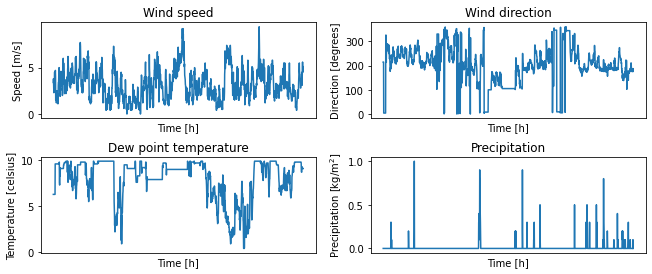

In [ ]:
xplot = np.arange(1,len(wind_speed)+1)

h1 = plt.subplot(221)
plt.plot(xplot, wind_speed.astype(float))
plt.xlabel('Time [h]')
h1.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Speed [m/s]')
plt.title('Wind speed')

h2 = plt.subplot(222)
plt.plot(xplot, wind_dir.astype(float))
plt.xlabel('Time [h]')
h2.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Direction [degrees]')
plt.title('Wind direction')

h3 = plt.subplot(223)
plt.plot(xplot, temp.astype(float))
h3.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Time [h]')
plt.ylabel('Temperature [celsius]')
plt.title('Dew point temperature')

h4 = plt.subplot(224)
plt.plot(xplot, precip.astype(float))
h4.tick_params(
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Time [h]')
plt.ylabel('Precipitation [kg/m$^2$]')
plt.title('Precipitation')

plt.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=0.9, wspace=0.2, hspace=0.4)

plt.show()

### Generate inputs

In [ ]:
# One-hot-encoding of inputs
tod = []        # Time of day
dotw = [] # Day of the week
rushhours = [7,8,9,15,16,17,18]  # Times of day with (estimated) rush hour (only weekdays)
days = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Checks if we are in rush hour
def rush(tid, dag):
  if tid in rushhours:
    if dag in days[0:5]:
     rh = 1
    else:
     rh = 0
  else:
    rh = 0
  return rh

for i in range(0,len(timeOD)):
  t = timeOD[i][0]
  day = datetime.strptime(t[0:10], '%Y-%m-%d').strftime('%A')
  time = int(t[11:13])
  dotw.append(day)
  tod.append(time)
dotw = np.array(dotw)
tod = np.array(tod)

x = np.zeros((len(timeOD),37))
for i in range(0,len(timeOD)):
  x[i,tod[i]] = 1                          # First encode time of day (first 24 slots)
  j = np.where(days == dotw[i])[0][0]+1  # Then encode day of week (next 7 slots)
  x[i,24+j] = 1
  x[i,24+8] = rush(tod[i],dotw[i])    # Then encode whether its rush hour or not
  x[i,33] = float(wind_speed[i])      # Then encode features about the wind speed
  x[i,34] = float(wind_dir[i])        # Then encode features about the wind direction
  x[i,35] = float(temp[i])            # Then encode features about the temperature
  x[i,36] = float(precip[i])          # Then encode features about the precipitation

test_size = round(0.67*len(x))

scaler1 = MinMaxScaler(feature_range = (0,1))
ymax = data.max()

r = int((len(data)-test_size)/2)
Xtrain = scaler1.fit_transform(x[0:test_size])
#Xval = scaler1.fit_transform(x[test_size:len(x)-r])
#Xtest = scaler1.fit_transform(x[len(x)-r:len(x)])
Xtest = scaler1.fit_transform(x[test_size:])
ytrain = data[0:test_size]/ymax
#yval = data[test_size:len(data)-r]/ymax
#ytest = data[len(data)-r:len(data)]/ymax
ytest = data[test_size:]/ymax


X_trainT = torch.tensor(Xtrain)
X_testT = torch.tensor(Xtest)
#X_valT = torch.tensor(Xval)
n = data.shape[1]

y_trainT = torch.zeros([len(ytrain), n**2], dtype=torch.float32)
y_testT = torch.zeros([len(ytest), n**2], dtype=torch.float32)
#y_valT = torch.zeros([len(yval), n**2], dtype=torch.float32)

for k in range(0,len(ytrain)):
  y_trainT[k,:] = ToTensor()(ytrain[k]).view(n**2)
#for k in range(0,len(yval)):
#  y_valT[k,:] = ToTensor()(yval[k]).view(n**2)
for k in range(0,len(ytest)):
  y_testT[k,:] = ToTensor()(ytest[k]).view(n**2)

train_data = TensorDataset(X_trainT,y_trainT)
test_data = TensorDataset(X_testT,y_testT)
#val_data = TensorDataset(X_valT,y_valT)

train_loader = DataLoader(train_data) # create dataloader for training set
test_loader = DataLoader(test_data) # create dataloader for test set
#val_loader = DataLoader(val_data) # create dataloader for validation set

# Check if our loader works
for x,y in train_loader:
  print(x)
  print(y)
  break

print(len(train_loader))
print(len(test_loader))
#print(len(val_loader))

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3696, 0.5974, 0.5982,
         0.0000]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])
981
483


### Plot of data

Let us visualize some of the data so we know what we are dealing with.

Code taken from: https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """ Create a heatmap from a numpy array and two lists of labels.
    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """ A function to annotate a heatmap.
    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts  

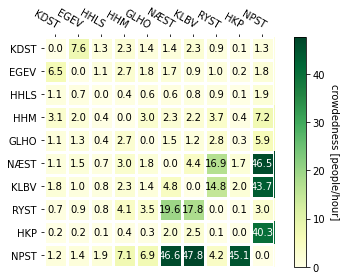

In [ ]:
# Plots of data, one of the OD matrices for example
data = d150
od = np.zeros((data.shape[1],data.shape[2]))
for i in range(0,data.shape[0]):
  od = od + data[i,:,:]

fig, ax = plt.subplots()
im, cbar = heatmap(od/len(data), sdata, sdata, ax=ax,
                   cmap="YlGn", cbarlabel="crowdedness [people/hour]")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

### Baseline

We will now try to make a Baseline model. We make a naive baseline which is just the average of all OD-matrices.

Test MSE: 66761.33980959
Test RMSE: 258.38215846
Test MAE: 2373.89570093


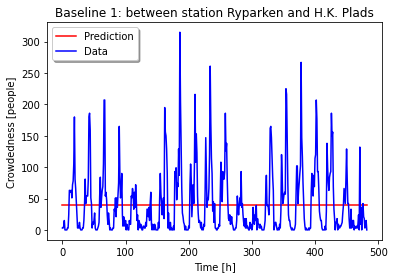

In [ ]:
# Naive baseline (simple average of all OD-matrices)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

od = np.zeros((data.shape[1],data.shape[2]))
for i in range(0,ytrain.shape[0]):
  od = od + ytrain[i,:,:]*ymax
Nbaseline = np.round(od/len(ytrain))

daybase = np.zeros((len(ytest),1))
timebase = np.zeros((len(ytest),1))
pred = np.zeros((len(ytest),10,10))
for i in range(0,len(ytest)):
  j = np.where(days == dotw[i])[0][0]+1  # Then encode day of week (next 7 slots)
  daybase[i,0] = j-1
  timebase[i,0] = tod[test_size+i]
  pred[i,:,:] = Nbaseline

# Compute RMSE
mse = 0
mae = 0
for k in range(0,len(ytest)):
  mse += mean_squared_error(pred[k], ytest[k])
  mae += mean_absolute_error(pred[k], ytest[k])
rmse = np.sqrt(mse)

print('Test MSE: %.8f' % mse)
print('Test RMSE: %.8f' % rmse)
print('Test MAE: %.8f' % mae) 

test_y = data[test_size:len(data)]
# Plot data and predictions         [:,9,8] er fucking hjernedød
fro = 8;
to = 9;
plt.plot(pred[:,fro,to], color = 'red', label = 'Prediction')
plt.plot(test_y[:,fro,to], color = 'blue', label = 'Data')
plt.xlabel('Time [h]')
plt.ylabel('Crowdedness [people]')
plt.title('Baseline 1: between station ' + sdatar[fro-1] + ' and ' + sdatar[to-1])
leg = plt.legend(loc='upper left', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(1)

We make a slightly more advanced baseline, taking the average of the previous same hours during all previous days


Test MSE: 108720.61504324
Test RMSE: 329.72809259
Test MAE: 2379.29747664


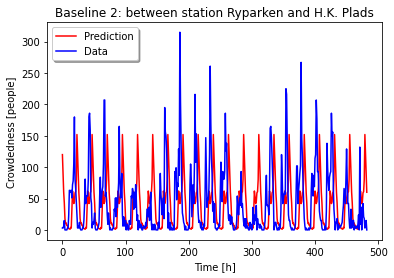

In [ ]:
# Baseline 2
sumdata = sum(data)

data_T = np.zeros((24,10,10))
for i in range(24):
    data_T[i,:,:] = sum(data[(i+19)%24::24])

#print("\namount of people in time 5:\n", data_T[5,:,:])

base2 = np.zeros((24,10,10))
for i in range(24):
    base2[i,:,:] = data_T[i,:,:] / len(tdata[(i+19)%24::24])
    
#print("\naverage for time 7:\n",base2[7,:,:])

# Test baseline on test set
timebase = np.zeros((len(ytest),1))
pred = np.zeros((len(ytest),10,10))
for i in range(0,len(ytest)):
  timebase[i,0] = tod[test_size+i]
  pred[i,:,:] = np.round(base2[int(timebase[i,0])])

# Compute RMSE
mse = 0
mae = 0
for k in range(0,len(ytest)):
  mse += mean_squared_error(pred[k], ytest[k])
  mae += mean_absolute_error(pred[k], ytest[k])
rmse = np.sqrt(mse)

print('Test MSE: %.8f' % mse)
print('Test RMSE: %.8f' % rmse)
print('Test MAE: %.8f' % mae) 

test_y = data[test_size:len(data)]
fro = 8;
to = 9;
# Plot data and predictions         [:,9,8] er fucking hjernedød
plt.plot(pred[:,fro,to], color = 'red', label = 'Prediction')
plt.plot(test_y[:,fro,to], color = 'blue', label = 'Data')
plt.xlabel('Time [h]')
plt.ylabel('Crowdedness [people]')
plt.title('Baseline 2: between station ' + sdatar[fro-1] + ' and ' + sdatar[to-1])
leg = plt.legend(loc='upper left', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(1)

Lastly we make the most advanced baseline, taking the average of the previous times at the previous (same, i.e. only mondays) days looking a fixed number of weeks back.

I.e. prediction of monday at 1 pm is the average of the past 5 mondays at 1 pm

Example: od-15-1H-20201101-60-demand.npy.gz consists of Timing Point OD-demand matrices for 15E, every time step is 1 hour, the time series is ending November 1 2020, and consists of 60 days of data leading up to this date. So for the weekly historical average, we need to figure out which slices of the OD-matrices correspond to which day. The time-series ends on 0:00 AM, November 1 2020, so this corresponds to the last measurement.

Test MSE: 81986.06572081
Test RMSE: 286.33208992
Test MAE: 2120.78219626


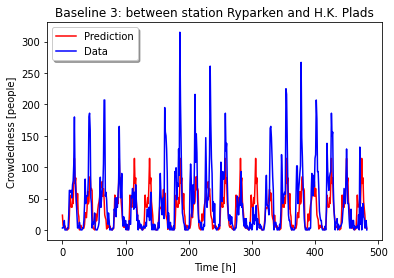

In [ ]:
from sklearn.metrics import mean_squared_error

# We consider a weekly historical average
# First sort od-slices into days, starting from t300[0]
#print('First data point:')
#print(t300[0])
# i.e. we start recording data at wednesday the 2nd of september at 0 in the morning. 
# This slice and the next 24-0=24 slices belong to the wednesday group
#print('First data point of next day:')
#print(t300[24])

# Figures out which time-slice indices belong to which day (mon-sun)
day = [[],[],[],[],[],[],[]]

g = 0
for i in range(0,ytrain.shape[0]):
  if i < 24:
    day[2].append(i)  # Start day = day 2 is wednesday
  if 24 + 168*g <= i <= 47 + 168*g:
    day[3].append(i)   
  if 47 + 168*g <= i <= 71 + 168*g:
    day[4].append(i)    
  if 72 + 168*g <= i <= 95 + 168*g:
    day[5].append(i)
  if 96 + 168*g <= i <= 119 + 168*g:
    day[6].append(i)
  if 120 + 168*g <= i <= 143 + 168*g:
    day[0].append(i)
  if 144 + 168*g <= i <= 168 + 168*g:
    day[1].append(i)    
  if 169 + 168*g <= i <= 192 + 168*g:
    day[2].append(i)
  if i == 192+168*g:
    g = g+1    

#print(len(day[0])+len(day[1])+len(day[2])+len(day[3])+len(day[4])+len(day[5])+len(day[6]))

# We now have the time-slices grouped up into days. To find the weekly historical average for some day at some time
# we also need to be able to find corresponding time-slices for the desired (day,time) of the historical average

# Baseline(dotw = 0,time = [8], 5)   (i.e. function called Baseline, with calls: dotw (day of the week) = 0-6, time = 0 (implicit that we mean 1 hour ahead from time we enter), n = 5 (how many weeks we look back))

def Baseline(dotw, time, n):
  """ Computes crowdedness on desired dotw (0-6 for mon-sun) and time (0-23, going forward 
  1 hour from input, eg. input 5 and get crowdedness between time 5 and 6) looking back n weeks """
  """ Check that dotw = [0,6], time = [0,24] and that n is not more than 6 weeks (we only have data for past 60 days, and training set is the first 2/3'rds of it) """
  if dotw > 6:
    print('Day of the week has to be between 0 and 6')
  elif time > 23:
    print('Time of day has to be between 0 and 23')
  elif n > 6:
    print('We can at most go back 6 weeks')

  pool = day[dotw]
  Tpool = pd.to_datetime(tdata[pool])
  hrs = np.zeros((len(Tpool)))
  for k in range(len(Tpool)):
    hrs[k] = str(Tpool[k].time())[0:2]
  match,  = np.where(hrs==time)
  des_match = match[0:n]
  tot = np.round(sum(data[des_match,:,:])/n,3)
  tot = np.array(tot)
  return tot

# Test baseline on test set
daybase = np.zeros((len(ytest),1))
timebase = np.zeros((len(ytest),1))
pred = np.zeros((len(ytest),10,10))
for i in range(0,len(ytest)):
  j = np.where(days == dotw[i])[0][0]+1  # Then encode day of week (next 7 slots)
  daybase[i,0] = j-1
  timebase[i,0] = tod[test_size+i]
  pred[i,:,:] = Baseline(int(daybase[i,0]),int(timebase[i,0]),6)

# Compute RMSE
mse = 0
mae = 0
for k in range(0,len(ytest)):
  mse += mean_squared_error(pred[k], ytest[k])
  mae += mean_absolute_error(pred[k], ytest[k])
rmse = np.sqrt(mse)

print('Test MSE: %.8f' % mse)
print('Test RMSE: %.8f' % rmse)
print('Test MAE: %.8f' % mae) 

test_y = data[test_size:len(data)]
fro = 8;
to = 9;

# Plot data and predictions         [:,9,8] er fucking hjernedød
plt.plot(pred[:,fro,to], color = 'red', label = 'Prediction')
plt.plot(test_y[:,fro,to], color = 'blue', label = 'Data')
plt.xlabel('Time [h]')
plt.ylabel('Crowdedness [people]')
plt.title('Baseline 3: between station ' + sdatar[fro-1] + ' and ' + sdatar[to-1])
leg = plt.legend(loc='upper left', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(1)


### Deep learning model

We now define our model. As we wish to predict the future demand we might as well try to predict the future OD-matrices, given 60 days worth of data sorted into one hour slices. This can be done by an Auto Encoder (AE). We first take our input and encode it into a lower dimensional representation using a neural network, and then decode that sparse representation of our inputs into the target OD matrix. We are thus predicting new OD-matrices given the input sequence, and use the original OD-matrices to compute the MSE-loss.  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [ ]:
class SupervisedAutoencoder(nn.Module): 
    """Supervised autoencoder"""
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(SupervisedAutoencoder, self).__init__()
        
        self.input_features = input_shape
        self.latent_features = latent_features
        self.observation_features = 100 

        # Inference Network
        # Encode the observation `x` 
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.input_features, out_features=64),
#            nn.ReLU(),
#            nn.Dropout(0.3, inplace = True),
#            nn.Linear(in_features=128, out_features=256),
#            nn.ReLU(),
#            nn.Dropout(0.3, inplace = True),
#            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.3, inplace = True),
            nn.Linear(in_features=64, out_features=latent_features),
            nn.ReLU()
        )
        
        # Generative Model
        # Decode the encoded observation
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=64),
#            nn.ReLU(),
#            nn.Dropout(0.3, inplace = True),
#            nn.Linear(in_features=64, out_features=256),
#            nn.ReLU(),
#            nn.Dropout(0.3, inplace = True),
#            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.3, inplace = True),
            nn.Linear(in_features=64, out_features=self.observation_features),
            nn.ReLU()
        )

    def forward(self, x):      
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # pass input through encoder
        xenc = self.encoder(x)
        
        # pass encoded input through decoder
        xdec = self.decoder(xenc)
        
        return xenc, xdec
    
latent_features = 4
input_shape = x[0].shape[0]
sae = SupervisedAutoencoder(input_shape, latent_features)
print(sae)

SupervisedAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=True)
    (3): Linear(in_features=64, out_features=4, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=True)
    (3): Linear(in_features=64, out_features=100, bias=True)
    (4): ReLU()
  )
)


### Training and Evaluation

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define the models, evaluator and optimizer

torch.manual_seed(420)

# VAE
latent_features = 10
sae = SupervisedAutoencoder(input_shape, latent_features)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min')   # Automatically reduces the learning rate if improvement stagnates for few epochs
lossfn = torch.nn.MSELoss()

# Track loss
training_loss, validation_loss = [], []

epoch = 0
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
sae = sae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    sae.train()

    # Go through each batch in the training dataset using the loader
    for x,y in train_loader:
        x = x.to(device)
        x = x.float()

        # perform a forward pass through the model and compute MSE
        xenc, xdec = sae(x)      
        loss = lossfn(xdec,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
            
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        sae.eval()
        
        #for x,y in val_loader:
        x = x.to(device)
        x = x.float()
          
        # perform a forward pass through the model and compute the MSE
        xenc, xdec = sae(x)
        val_loss = lossfn(xdec,y)
        scheduler.step(val_loss)
          
        # Update loss
        epoch_validation_loss += val_loss.detach().numpy()
    
    training_loss.append(epoch_training_loss/len(train_loader))
    validation_loss.append(epoch_validation_loss)#/len(val_loader))

    # Print loss every epoch
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

>> Using device: cpu
Epoch 1, training loss: 0.0013252903643347466, validation loss: 0.00043689378071576357
Epoch 2, training loss: 0.0008406569276804911, validation loss: 0.0008209598017856479
Epoch 3, training loss: 0.0007478439627984199, validation loss: 0.0006424557650461793
Epoch 4, training loss: 0.0006963289016938657, validation loss: 0.0007949892897158861
Epoch 5, training loss: 0.0006079093027943843, validation loss: 0.0006110554677434266
Epoch 6, training loss: 0.000571224600402104, validation loss: 0.0006417569238692522
Epoch 7, training loss: 0.0005366435248732226, validation loss: 0.0009182567009702325
Epoch 8, training loss: 0.0005434315864183063, validation loss: 0.0009029350476339459
Epoch 9, training loss: 0.0005251440121871636, validation loss: 0.000891753239557147
Epoch 10, training loss: 0.0005166441778839543, validation loss: 0.0008070559706538916
Epoch 11, training loss: 0.0005272135942793222, validation loss: 0.000775570108089596
Epoch 12, training loss: 0.000505

Test MSE: 107276.76653856
Test RMSE: 327.53132146
Test MAE: 1762.20766355


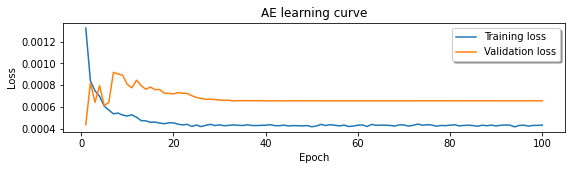

In [ ]:
from sklearn.metrics import mean_squared_error

xtest = X_testT.float()
# perform a forward pass through the model and compute the MSE
test_enc, test_dec = sae(xtest)

input = scaler1.inverse_transform(xtest).astype(int)
test_pred = np.zeros(ytest.shape)
for i in range(0,len(test_pred)):
  test_pred[i] = np.round(test_dec[i].detach().numpy().reshape((10,10))*ymax)

# Compute RMSE
mse = 0
mae = 0
for k in range(0,len(ytest)):
  mse += mean_squared_error(test_pred[k], ytest[k])
  mae += mean_absolute_error(test_pred[k], ytest[k])
rmse = np.sqrt(mse)

print('Test MSE: %.8f' % mse)
print('Test RMSE: %.8f' % rmse)
print('Test MAE: %.8f' % mae) 

# Plot learning curves
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

epok = np.arange(1,num_epochs+1)

plt.figure(figsize=(9,2))
plt.plot(epok, training_loss, label = 'Training loss')
plt.plot(epok, validation_loss, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('AE learning curve')
leg = plt.legend(loc='best', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(1)

plt.show()


In [ ]:
# Test the network
rushhours = [7,8,9,15,16,17,18]  # Times of day with (estimated) rush hour (only weekdays)
days = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
x = np.zeros((len(timeOD),37))

def input_generator(time, d, ws, wd, t, pre):
  x = np.zeros((1,37))
  x[0,time] = 1
  j = np.where(days == d)[0][0]+1  # Then encode day of week (next 7 slots)
  x[0,24+j] = 1
  x[0,24+8] = rush(time,d)    # Then encode whether its rush hour or not
  x[0,33] = ws   # wind speed in m/s
  x[0,34] = wd   # wind direction in degrees (360 is north: https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476621)
  x[0,35] = t    # dew point temperature in degrees Celsius (https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476616)
  x[0,36] = float(pre)  # accumulated precipitation in the latest 10 minutes. kg/m² is equivalent to mm. (see link above)
  x = torch.tensor(scaler1.fit_transform(x))
  x = x.float()
  return x

# We want to predict an OD matrix for eg. a tuesday between 16-17 where it is pouring down rain, 5 deg C and wind blowing 4 m/s south
x = input_generator(16, 'Tuesday', 4, 180, 5, 1)

# perform a forward pass through the model
xenc, xdec = sae(x)

input = scaler1.inverse_transform(x).astype(int)
pred = (xdec.detach().numpy().reshape((10,10))*ymax).astype(int)

#print(xenc.detach().numpy())
#print(pred)

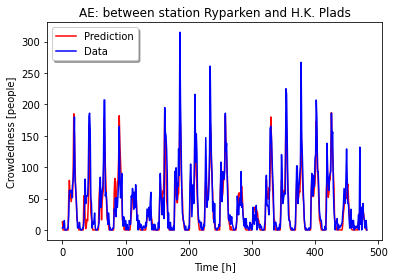

In [ ]:
test_y = data[test_size:len(data)]
fro = 8;
to = 9;

# Plot data and predictions         [:,9,8] er fucking hjernedød
plt.plot(test_pred[:,fro,to], color = 'red', label = 'Prediction')
plt.plot(test_y[:,fro,to], color = 'blue', label = 'Data')
plt.xlabel('Time [h]')
plt.ylabel('Crowdedness [people]')
plt.title('AE: between station ' + sdatar[fro-1] + ' and ' + sdatar[to-1])
leg = plt.legend(loc='upper left', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(1)

plt.show()

We look at the weights of the first layer, to see which features have the highest weights, i.e. most importance.

In [ ]:
ww = sae.encoder[0].weight

print(ww.shape)

print(ww)

torch.Size([64, 37])
Parameter containing:
tensor([[ 0.0855, -0.0990,  0.1303,  ..., -0.1698, -0.0718, -0.0108],
        [ 0.0265, -0.1446,  0.0280,  ..., -0.1069, -0.1688,  0.0366],
        [-0.1291,  0.0963,  0.0200,  ..., -0.1514, -0.1421,  0.1322],
        ...,
        [-0.1577,  0.2772,  0.4015,  ...,  0.0614, -0.0367,  0.0409],
        [-0.0414, -0.0399, -0.0345,  ..., -0.3818, -0.0953, -0.0048],
        [-0.1576, -0.1924, -0.0838,  ...,  0.0183, -0.1428, -0.0618]],
       requires_grad=True)


We now propagate the output from our encoder into the LSTM network

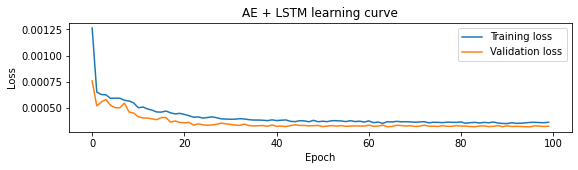

In [ ]:
from keras.layers import Dropout

# Fix random seed for reproducibility
np.random.seed(5)

# Start by extracting the relevant sequences (encoding of all inputs from training- and testset)
seq = []
for x,y in train_loader:
  x = x.float()
  xenc, xdec = sae(x)
  seq.append(xenc.detach().numpy())
#for x,y in val_loader:
#  x = x.float()
#  xenc, xdec = sae(x)
#  seq.append(xenc.detach().numpy())
for x,y in test_loader:
  x = x.float()
  xenc, xdec = sae(x)
  seq.append(xenc.detach().numpy())
seq = np.array(seq)
seq = seq.reshape((len(seq),latent_features))

# Dataset
dataset = pd.DataFrame(seq) # Save as dataframe
dataset = dataset.astype('float32') # Convert to floating point values 
values = dataset.values # Extract values
#values = values.transpose() # Transpose such that each column corresponds to a time series

# Number of samples, timesteps and features
n_timesteps = 1
n_samples = values.shape[0]
n_features = values.shape[1]

# Normalize features
scaler3 = MinMaxScaler(feature_range=(0, 1))
values = scaler3.fit_transform(values)

# Split into training, validation and test data
n_train_hours = round(n_samples*0.67)
values = values.reshape((len(seq),1,latent_features))
train = values[:n_train_hours, :]
#val = values[n_train_hours:len(seq)-r, :]
#test = values[len(seq)-r:, :]
test = values[n_train_hours:, :]

y = data
ytrain = y[0:n_train_hours]
#yval = y[n_train_hours:len(data)-r]
#ytest = y[len(data)-r:]
ytest = y[n_train_hours:]

maxy = y.max()
yytrain = ytrain/maxy
yytest = ytest/maxy
#yyval = yval/maxy

# Split into input and outputs
train_X, train_y = train,  yytrain.reshape((n_train_hours,1,100))
#val_X, val_y = val,  yyval.reshape((len(yval),1,100))
test_X, test_y = test, yytest.reshape((len(ytest),1,100))

# Model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True ))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, activation='relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu'))
model.compile(loss='mse', optimizer='adam')

# Train model
#history = model.fit(train_X, train_y, epochs=100, batch_size=1, validation_data = (val_X, val_y), verbose=0, shuffle=False)
history = model.fit(train_X, train_y, epochs=100, batch_size=1, validation_split = 0.3, verbose=0, shuffle=False)

# Plot history
plt.figure(figsize=(9,2))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('AE + LSTM learning curve')
plt.legend()
plt.show()

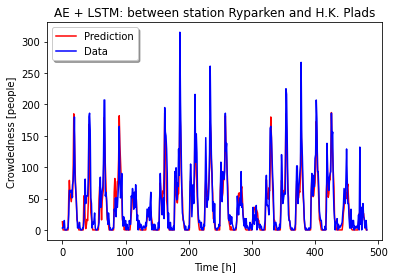

In [ ]:
# Make predictions
yhat = model.predict(test_X)
yhatr = yhat.reshape((len(test_X),10,10))

inv_yhatr = np.round(yhatr*ymax)

# Compute RMSE
mse = 0
mae = 0
for k in range(0,len(ytest)):
  mse += mean_squared_error(inv_yhatr[k], ytest[k])
  mae += mean_absolute_error(inv_yhatr[k], ytest[k])
rmse = np.sqrt(mse)

print('Test MSE: %.8f' % mse)
print('Test RMSE: %.8f' % rmse)
print('Test MAE: %.8f' % mae) 

#plt.figure(figsize=(14,14))
# Plot data and predictions 
#for i in range(10):
#  for j in range(10):
#    plt.subplot2grid((10,10), (i,j))
#    plt.plot(inv_yhatr[:,i,j], color = 'red')
#    plt.plot(ytest[:,i,j], color = 'blue')
#    plt.title(sdatar[i] + '-' + sdatar[j])
#plt.subplots_adjust(left=0.1, bottom=0.2, right=1.8, top=1.1, wspace=0.7, hspace=0.7)
#plt.show()

to = 9
fro = 8

plt.plot(test_pred[:,fro,to], color = 'red', label = 'Prediction')
plt.plot(ytest[:,fro,to], color = 'blue', label = 'Data')
plt.xlabel('Time [h]')
plt.ylabel('Crowdedness [people]')
plt.title('AE + LSTM: between station ' + sdatar[fro-1] + ' and ' + sdatar[to-1])
leg = plt.legend(loc='upper left', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(1)

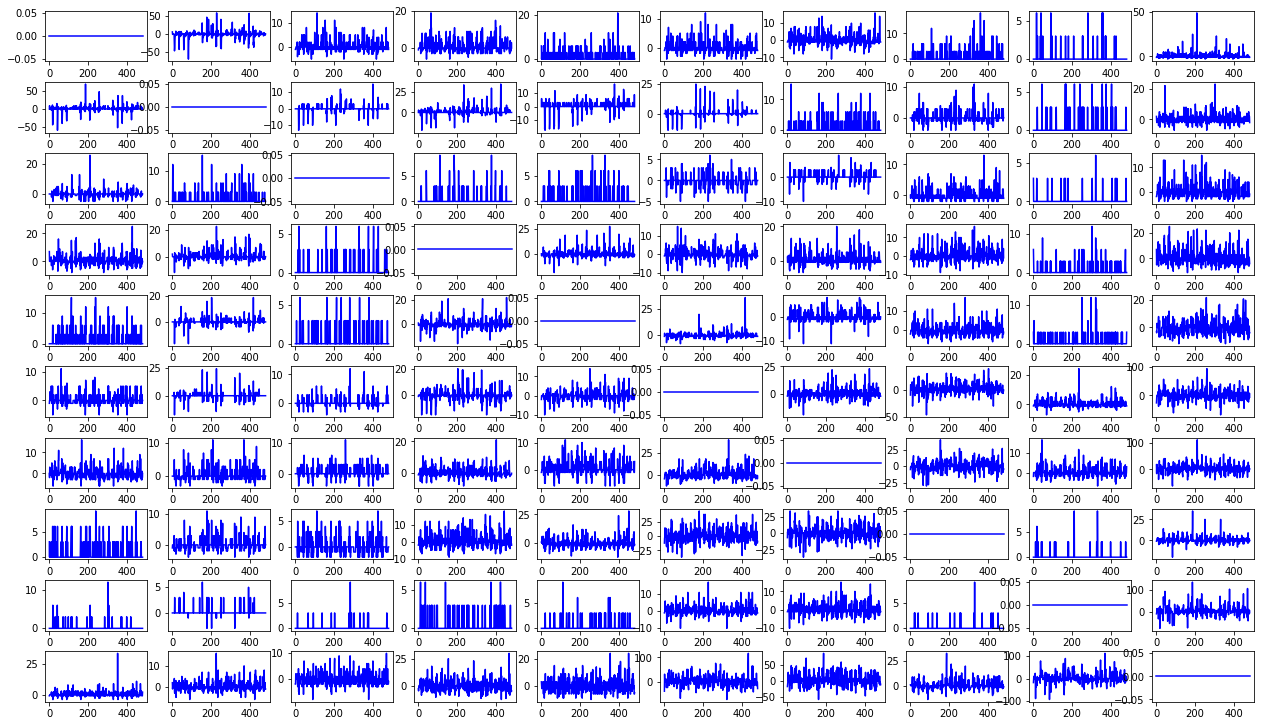

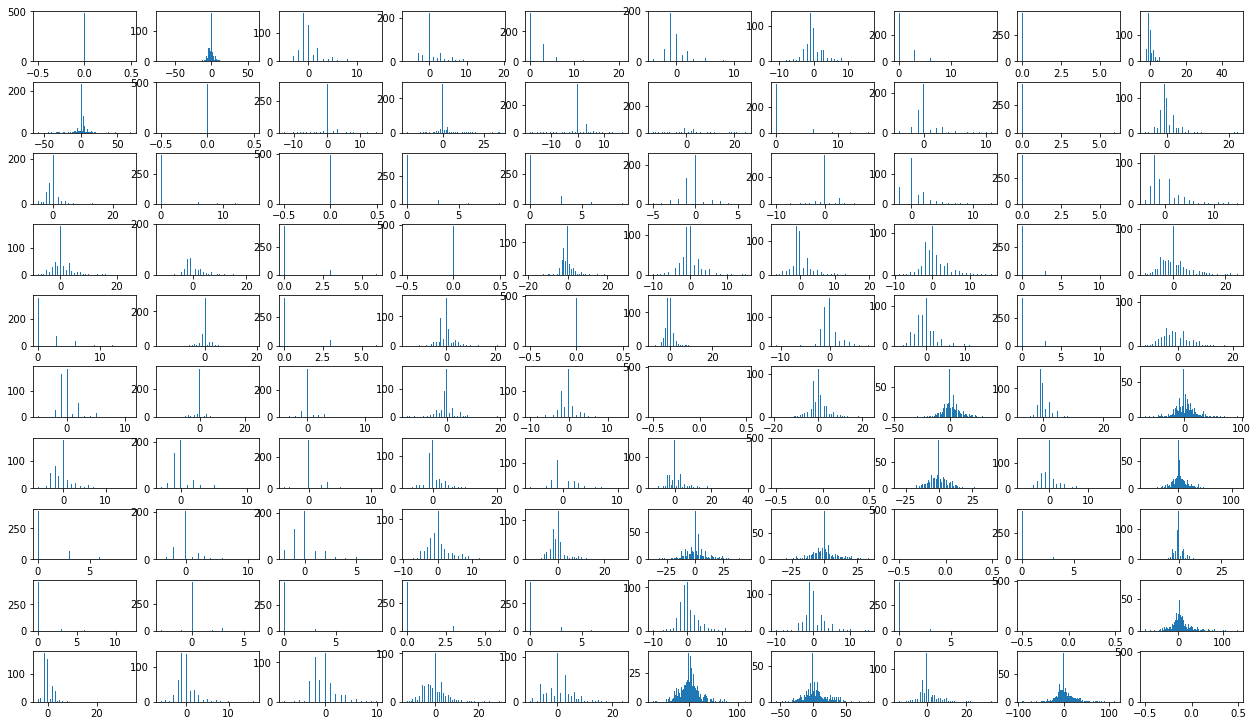

In [ ]:
# Plot residuals
plt.figure(figsize=(12,12))
# Plot data and predictions 
for i in range(10):
  for j in range(10):
    plt.subplot2grid((10,10), (i,j))
    plt.plot(ytest[:,i,j]-inv_yhatr[:,i,j], color = 'blue')

plt.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

# Plot histograms of residuals
plt.figure(figsize=(12,12))
# Plot data and predictions 
for i in range(10):
  for j in range(10):
    plt.subplot2grid((10,10), (i,j))
    plt.hist(ytest[:,i,j]-inv_yhatr[:,i,j], bins = 100)

plt.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

But how would our LSTM network perform if we had just trained it on the original dataset, instead of first passing the data through the encoder?

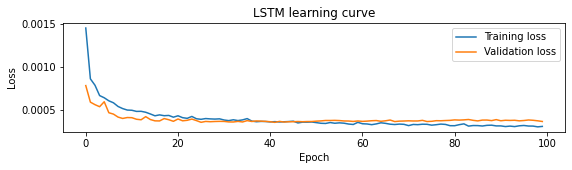

Test MSE: 19643.21000000
Test RMSE: 140.15423647
Test MAE: 1123.21000000


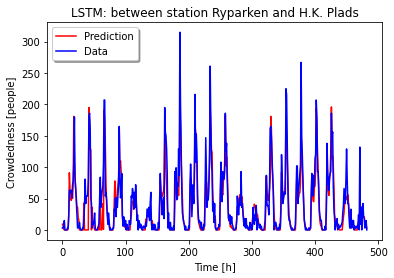

In [ ]:
from keras.layers import Dropout

# Fix random seed for reproducibility
np.random.seed(5)

lx = np.zeros((len(timeOD),37))
for i in range(0,len(timeOD)):
  lx[i,tod[i]] = 1                          # First encode time of day (first 24 slots)
  j = np.where(days == dotw[i])[0][0]+1  # Then encode day of week (next 7 slots)
  lx[i,24+j] = 1
  lx[i,24+8] = rush(tod[i],dotw[i])    # Then encode whether its rush hour or not
  lx[i,33] = float(wind_speed[i])      # Then encode features about the wind speed
  lx[i,34] = float(wind_dir[i])        # Then encode features about the wind direction
  lx[i,35] = float(temp[i])            # Then encode features about the temperature
  lx[i,36] = float(precip[i])          # Then encode features about the precipitation

test_size = round(0.67*len(lx))

scaler1 = MinMaxScaler(feature_range = (0,1))
ymax = data.max()

r = int((len(data)-test_size)/2)
lXtrain = scaler1.fit_transform(lx[0:test_size])
lXtest = scaler1.fit_transform(lx[test_size:])
lytrain = data[0:test_size]/ymax
lytest = data[test_size:]/ymax

# Number of samples, timesteps and features
n_timesteps = 1
n_samples = lx.shape[0]
n_features = lx.shape[1]

# Normalize features
scaler3 = MinMaxScaler(feature_range=(0, 1))
lx = scaler3.fit_transform(lx)

# Split into training, validation and test data
n_train_hours = round(n_samples*0.67)
ltrain = lx[:n_train_hours, :]
ltest = lx[n_train_hours:, :]

ly = data
lytrain = ly[0:n_train_hours]
lytest = ly[n_train_hours:]

lmaxy = ly.max()
lyytrain = lytrain/maxy
lyytest = lytest/maxy

# Split into input and outputs
ltrain_X, ltrain_y = ltrain.reshape((len(ltrain),1,37)),  lyytrain.reshape((len(lytrain),1,100))
ltest_X, ltest_y = ltest.reshape((len(ltest),1,37)), lyytest.reshape((len(lytest),1,100))

# Model
model1 = Sequential()
model1.add(LSTM(32, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]), return_sequences=True ))
model1.add(Dropout(0.2))
model1.add(LSTM(64, activation='relu',return_sequences=True))
model1.add(Dropout(0.3))
#model.add(LSTM(128, activation='relu', return_sequences = True))
#model.add(Dropout(0.3))
model1.add(LSTM(100, activation='relu'))
model1.compile(loss='mse', optimizer='adam')

# Train model
lhistory = model1.fit(ltrain_X, ltrain_y, epochs=100, batch_size=1, validation_split = 0.3, verbose=0, shuffle=False)

plt.figure(figsize=(9,2))
# Plot history
plt.plot(lhistory.history['loss'], label='Training loss')
plt.plot(lhistory.history['val_loss'], label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('LSTM learning curve')
plt.legend()
plt.show()

# Make predictions
lyhat = model1.predict(ltest_X)
lyhatr = lyhat.reshape((len(ltest_X),10,10))

linv_yhatr = np.round(lyhatr*ymax)

# Compute RMSE
mse = 0
mae = 0
for k in range(0,len(lytest)):
  mse += mean_squared_error(linv_yhatr[k], lytest[k])
  mae += mean_absolute_error(linv_yhatr[k], lytest[k])
rmse = np.sqrt(mse)

print('Test MSE: %.8f' % mse)
print('Test RMSE: %.8f' % rmse)
print('Test MAE: %.8f' % mae) 

to = 9
fro = 8

plt.plot(linv_yhatr[:,fro,to], color = 'red', label = 'Prediction')
plt.plot(lytest[:,fro,to], color = 'blue', label = 'Data')
plt.xlabel('Time [h]')
plt.ylabel('Crowdedness [people]')
plt.title('LSTM: between station ' + sdatar[fro-1] + ' and ' + sdatar[to-1])
leg = plt.legend(loc='upper left', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(1)

We see that our combination of an autoencoder and a recurrent neural network based on LSTM cells, actually performs better than the recurrent neural network alone. Therefore we conclude that the dimensionality reduction done by the encoder is actually worth the effort as proved by our testing.